In [171]:
import os,sys, h5py, pdb,time, glob
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log, log as ln
from astropy import units as un, constants as cons
import scipy, scipy.stats
from matplotlib import ticker, patches
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../../pysrc')

In [2]:
import workdirs as wd
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')
figdir = wd.basedir+'figures/'

Behroozi+18 not loaded
palettable colormaps are not installed
don't have phil's colormaps


In [3]:
CF_path = wd.basedir + '/../cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [159]:
simnames = ['vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking',
            'vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb10',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb100',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e3']
simname_template = 'vc200_Rs%d_Mdot%d_Rcirc%d_fgas02_res1e4_vturb%d'
vc = 200. *un.km/un.s 
Rcirc = 1.*un.kpc
for isim in range(1,4):
    for ivt,vturb in enumerate((3,30,100)):
        if isim==0: Rsonic,Mdot = 0,   226
        if isim==1: Rsonic,Mdot = 0.05,1212
        if isim==2: Rsonic,Mdot = 3,   3668
        if isim==3: Rsonic,Mdot = 20,  4536        
        simnames.append( simname_template%(Rsonic,Mdot,Rcirc.value,vturb))

# running particle analysis on all sims

In [170]:
for isim,simname in enumerate(simnames):
    rmax = (40,30)[isim>=1 and isim<=9]
    Nsnapshots = (225,400)[isim>=1 and isim<=9]
    dt = snapshot_dt_Myr = (10,50)[isim>=7]
    Rcirc = float(simname.split('_')[3][5:])*un.kpc
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=snapshot_dt_Myr,pr=False,
          analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    lastSnapshot = sim.Nsnapshots()-1    
    snapshotInds = np.arange(lastSnapshot-100//(dt/10),lastSnapshot,dSnapshot)
    dSnapshot = 10//(dt/10)
    #     _ = os.system('grep TimeBetSnapshot %s../params.txt'%simdir)
    print('sbatch rusty_run.sh %s %d_%d_%d %d %d %d'%(simname,Nsnapshots,dt,rmax,snapshotInds[0],snapshotInds[-1],dSnapshot))

sbatch rusty_run.sh vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking 225_10_40 224 314 10
sbatch rusty_run.sh vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30 400_10_30 85 175 10
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30 400_10_30 329 419 10
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4 400_10_30 129 219 10
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb10 400_10_30 309 399 10
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb100 400_10_30 362 452 10
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e3 400_10_30 55 145 10
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb3 400_50_30 131 141 2
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb30 400_50_30 123 141 2
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb100 400_50_30 147 165 2
sbatch rusty_run.sh vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb3 225_50_40 59 77 2
sbatch rusty_run.sh vc20

# connect all files from the same sim

In [173]:
for isim,simname in enumerate(simnames[:]):
    dt = snapshot_dt_Myr = (10,50)[isim>=7]
    rmax = (40,30)[isim>=1 and isim<=9]
    Nsnapshots = (225,400)[isim>=1 and isim<=9]
    vc = 200. *un.km/un.s
    Rcirc = float(simname.split('_')[3][5:])*un.kpc
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=snapshot_dt_Myr,pr=False,
          analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function    
    actual_Nsnapshots = Nsnapshots // (dt//10)
    lastSnapshot = sim.Nsnapshots()-1; dSnapshot = 10//(dt/10)
    snapshotInds = np.arange(lastSnapshot-100//(dt/10),lastSnapshot,dSnapshot)
    coords,vs,Ts,nHs,tcools = np.zeros((actual_Nsnapshots,0,3)), np.zeros((actual_Nsnapshots,0,3)), np.zeros((actual_Nsnapshots,0)), np.zeros((actual_Nsnapshots,0)), np.zeros((actual_Nsnapshots,0))
    for lastSnapshot_of_track in snapshotInds:
        if lastSnapshot_of_track-actual_Nsnapshots<0: continue
        npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_%d.npz'%(Nsnapshots,dt,rmax,lastSnapshot_of_track)
        #snapNumbers = range(lastSnapshot-Nsnapshots,lastSnapshot,1)

        if os.path.exists(npz_fn):
            f = np.load(npz_fn)
        else:
            print(npz_fn)
            continue
        coords = np.concatenate([coords,f['coords']],axis=1)
        vs = np.concatenate([vs,f['vs']],axis=1)
        Ts = np.concatenate([Ts,f['Ts']],axis=1)
        nHs = np.concatenate([nHs,f['nHs']],axis=1)
        tcools = np.concatenate([tcools,f['tcools']],axis=1)
        f.close()
    if coords.shape[1]==0: continue
    print(lastSnapshot, coords.shape)
    npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_all.npz'%(Nsnapshots,dt,rmax)
    np.savez(npz_fn,coords=coords,vs=vs,Ts=Ts,nHs=nHs,tcools=tcools)

/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking/particle_tracks_225_10_40_234.npz
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking/particle_tracks_225_10_40_244.npz
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking/particle_tracks_225_10_40_254.npz
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking/particle_tracks_225_10_40_264.npz
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking/particle_tracks_225_10_40_274.npz
324 (225, 170108, 3)
429 (400, 36948, 3)
462 (400, 102844, 3)
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb3/particle_tracks_400_50_30_143.npz
/mnt/home/jstern/ceph/sim_analysis/particle_tracks/vc200_Rs0_

<function my_utils.mifkad(arr)>

vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking {False: 170096, True: 12}
vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30 {False: 36948}


/tmp/ipykernel_657878/189544408.py:32: RuntimeWarning: Mean of empty slice
  pl.plot(ts_offset,np.nanmean(Ts_arr[simname],axis=1))


vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb100 {False: 89378, True: 13466}
vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb3 {False: 113592}


/tmp/ipykernel_657878/189544408.py:32: RuntimeWarning: Mean of empty slice
  pl.plot(ts_offset,np.nanmean(Ts_arr[simname],axis=1))


vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb30 {False: 186508, True: 2292}
vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb100 {True: 130346, False: 37240}
vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb3 {False: 95804}


/tmp/ipykernel_657878/189544408.py:32: RuntimeWarning: Mean of empty slice
  pl.plot(ts_offset,np.nanmean(Ts_arr[simname],axis=1))


vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb30 {False: 92348}


/tmp/ipykernel_657878/189544408.py:32: RuntimeWarning: Mean of empty slice
  pl.plot(ts_offset,np.nanmean(Ts_arr[simname],axis=1))


vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb100 {False: 83271, True: 47}
vc200_Rs20_Mdot4536_Rcirc1_fgas02_res1e4_vturb3 {False: 11892}


/tmp/ipykernel_657878/189544408.py:32: RuntimeWarning: Mean of empty slice
  pl.plot(ts_offset,np.nanmean(Ts_arr[simname],axis=1))


vc200_Rs20_Mdot4536_Rcirc1_fgas02_res1e4_vturb100 {False: 36245}


/tmp/ipykernel_657878/189544408.py:32: RuntimeWarning: Mean of empty slice
  pl.plot(ts_offset,np.nanmean(Ts_arr[simname],axis=1))


[]

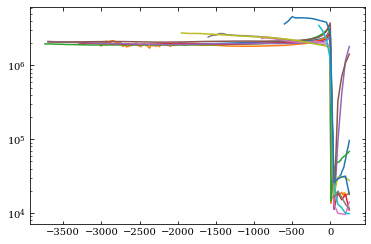

In [181]:
dphis_arr = {}
Ts_arr = {}
for isim,simname in enumerate(simnames):
    vc = 200. *un.km/un.s
    Rcirc = float(simname.split('_')[3][5:])*un.kpc
    dt = (10,50)[isim>=7]    
    rmax = (40,30)[isim>=1 and isim<=9]
    Nsnapshots = (225,400)[isim>=1 and isim<=9]
    actual_Nsnapshots = Nsnapshots // (dt//10)
    time_after_105 = 25 //(dt//10) 
    ts = -np.arange(actual_Nsnapshots)*dt
    ts = ts-ts[-1]
    ts_offset = -np.arange(-time_after_105*dt,(actual_Nsnapshots-time_after_105)*dt,dt)
    npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_all.npz'%(Nsnapshots,dt,rmax)
    if not os.path.exists(npz_fn): continue
    f = np.load(npz_fn)
    coords,vs,Ts,nHs,tcools=f['coords'],f['vs'],f['Ts'],f['nHs'],f['tcools']
    isStar = np.isnan(Ts[:,:])
    isCool = isStar + (Ts[:,:]<1e5)
    t105_ind = np.array([np.concatenate([np.array([True]), isCool[:,i]]).nonzero()[0][-1] for i in range(isCool.shape[1])])
    print(simname, ff.u.mifkad(t105_ind==0))
#     t105= ts[t105_ind]
    xs,ys,zs = coords[:,:,0],coords[:,:,1],coords[:,:,2]
    rs    = (xs**2+ys**2+zs**2)**0.5
    Rs    = (xs**2+ys**2)**0.5
    phis  = np.arctan2(ys,xs)
    dphis = (phis[:-1,:]-phis[1:,:])%(2*np.pi)    
    dphis = np.pad(dphis,((0,1),(0,0)),mode='constant')
    dphis_arr[simname] = shift_arr(dphis[:,t105_ind!=0],t105_ind[t105_ind!=0],actual_Nsnapshots,time_after_105)
    Ts_arr[simname]    = shift_arr(Ts[:,t105_ind!=0],   t105_ind[t105_ind!=0],actual_Nsnapshots,time_after_105)
    
    pl.plot(ts_offset,np.nanmean(Ts_arr[simname],axis=1))
pl.semilogy()  
#     totalPhis[simname] = (dphis*(1-isCool)*(1-isStar)).sum(axis=0)

In [169]:
1.9*(10/0.2)**0.5

13.435028842544403

vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking 9.041930069152885
vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30 11.86863903872931


/tmp/ipykernel_657878/1166116662.py:17: RuntimeWarning: Mean of empty slice
  ys = np.nanmean(dphis_arr[simname],axis=1)


vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb100 100.25936200868486
vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb3 22.472829532875423
vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb3 16.30560448267352
vc200_Rs20_Mdot4536_Rcirc1_fgas02_res1e4_vturb3 2.529593009326403


/tmp/ipykernel_657878/1166116662.py:17: RuntimeWarning: Mean of empty slice
  ys = np.nanmean(dphis_arr[simname],axis=1)
/tmp/ipykernel_657878/1166116662.py:17: RuntimeWarning: Mean of empty slice
  ys = np.nanmean(dphis_arr[simname],axis=1)
/tmp/ipykernel_657878/1166116662.py:17: RuntimeWarning: Mean of empty slice
  ys = np.nanmean(dphis_arr[simname],axis=1)


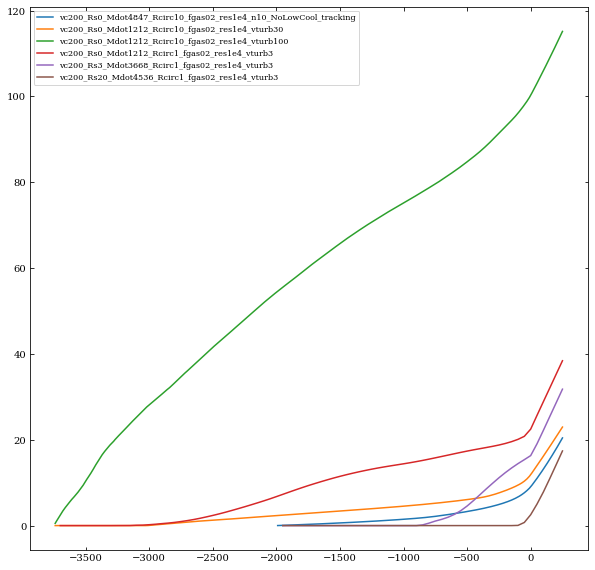

In [195]:
pl.figure(figsize=(10,10))
for isim,simname in enumerate(simnames):
    Rcirc = float(simname.split('_')[3][5:])*un.kpc
    rmax = (40,30)[isim>=1 and isim<=9]
    Nsnapshots = (225,400)[isim>=1 and isim<=9]
#     if isim not in (0,10,13):continue
    dt = (10,50)[isim>=7]    
    actual_Nsnapshots = Nsnapshots // (dt//10)
    time_after_105 = 25 //(dt//10) 
    ts_offset = -np.arange(-time_after_105*dt,(actual_Nsnapshots-time_after_105)*dt,dt)
    if len(simname.split('_'))==7:
        vturb = float(simname.split('_')[6][5:])*un.km/un.s
    else: vturb = 1e-3*un.km/un.s #for color
#     c = pl.get_cmap('viridis')(1-log(vturb.value)/2.5)
    if Rcirc==1*un.kpc and vturb>3*un.km/un.s: continue
    if simname in Ts_arr.keys():
        ys = np.nanmean(dphis_arr[simname],axis=1)
        pl.plot(ts_offset,np.nancumsum(ys[::-1])[::-1],label=simname)
        print(simname,np.nansum(ys[time_after_105:]))
pl.legend(fontsize=8)

[[<matplotlib.lines.Line2D at 0x1552f2663520>],

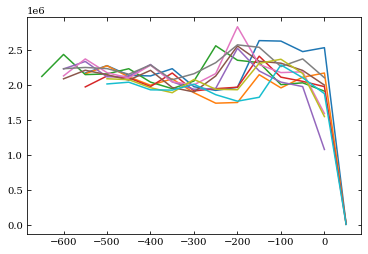

In [132]:
[pl.plot(ts_offset,shift_arr(Ts[:,i:i+1],  t105_ind[i:i+1],actual_Nsnapshots,time_after_105)) for i in range(10)]

In [116]:
def shift_arr(arr,t_offset_ind,actual_Nsnapshots,time_after_105):
    shifted_arr = np.zeros(arr.shape)
    for i in range(arr.shape[1]):
        shifted_arr[:,i] = np.roll(arr[:,i],-t_offset_ind[i])
        shifted_arr[actual_Nsnapshots-t_offset_ind[i]:actual_Nsnapshots-time_after_105,i] = np.nan
    return np.roll(shifted_arr, time_after_105,axis=0)


In [ ]:
def med_and_std_shift(all_vals,xs=ts_offset,theta_inds=theta_inds,show_std=True,ls='-'):
    for i,ind in enumerate(theta_midbins):
        _vals = all_vals[:,theta_inds[i]]
        vals = shift_arr(_vals,t105_ind[theta_inds[i]])
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        inds = ys16>0
        pl.plot(xs[inds]/1000,ys50[inds],label=labels[i],c=colors[i],ls=ls)
        if show_std: pl.fill_between(xs[inds]/1000,ys16[inds],ys84[inds],facecolor=colors[i],alpha=0.1)    


In [ ]:
def med_and_std_dphi(dphis,xs=ts,theta_inds=theta_inds):
    for i,ind in enumerate(theta_midbins):
        vals = dphis[:,theta_inds[i]]
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        goods = xs<np.median(tSF[theta_inds[i]])
        for j in np.arange(0,max(ys50[goods]/(2*np.pi))+1):
            goods2 = goods & (ys50//(2*np.pi) == j)
            pl.plot(xs[goods2]/1000,ys50[goods2]/(2*np.pi)%1,label=labels[i],c=colors[i])
            pl.fill_between(xs[goods2]/1000,ys16[goods2]/(2*np.pi)%1,ys84[goods2]/(2*np.pi)%1,facecolor=colors[i],alpha=0.1)            

In [57]:
for isim,simname in enumerate(simnames):
    if len(simname.split('_'))==7:
        vturb = float(simname.split('_')[6][5:])*un.km/un.s
    else: vturb = 1e-3*un.km/un.s #for color
    if vturb.value>3: continue

    if simname in totalPhis.keys():
        print(simname,totalPhis[simname].mean(),totalPhis[simname].std())

vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb3 34.137272320622415 45.84921788850131
vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb3 13.344675735110865 16.99716127692641
vc200_Rs20_Mdot4536_Rcirc1_fgas02_res1e4_vturb3 2.282571273289917 3.632161149122476


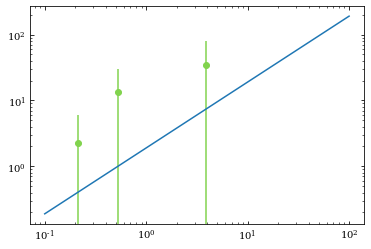

In [56]:
pl.figure()
for isim,simname in enumerate(simnames):
    if simname not in totalPhis.keys(): continue
    if len(simname.split('_'))==7:
        vturb = float(simname.split('_')[6][5:])*un.km/un.s
    else: vturb = 1e-3*un.km/un.s #for color
    if vturb.value>3: continue
    Rcirc = float(simname.split('_')[3][5:])*un.kpc                          
    Rsonic = float(simname.split('_')[1][2:])*un.kpc                          
    if Rsonic==0*un.kpc: Rsonic = 0.05*un.kpc
    t_ratio_at_Rcirc = (Rcirc/Rsonic)**0.5
    c = pl.get_cmap('viridis')(1-log(vturb.value)/2.5)
    marker = 'ox'[(Rcirc.value==10).astype(int)]
    pl.errorbar([t_ratio_at_Rcirc*10.**np.random.normal(0,0.05)],
               [totalPhis[simname].mean()],
               [totalPhis[simname].std()],
               color=c,marker=marker)
pl.loglog()
xs = np.array([0.1,100])
pl.plot(xs,1.9*xs)


0.19239644767571878